# WaveNet Vocoder Recipe Demonstration

**Tomoki Hayashi**

Department of Infomatics, Nagoya University  
Human Dataware Lab. Co., Ltd.

In [ ]:
import time
start_time = time.time()

## TIPS on Google Colab

- Cau use `<tab>` completion
- Can write the python code in code block
- Can also write a shell command with `!` e.g. `!ls`
- Can add new code block in via `+ code` button in the left above
- Not recommend to use intractive command such as `less`
- Run the currect block with `<ctrl> + <Enter>`
- Run the current block and move on the next with `<shift> + <Enter>`

In [3]:
# (Optional) here you can add some commands to check the behavior
!echo "hello, world"
print("hello, world.")

hello, world
hello, world.


## Environmental setup

First, install dependecies (It takes several minutes).

In [4]:
!git clone https://github.com/kan-bayashi/PytorchWaveNetVocoder.git -b is18_tutorial
import os
os.chdir("./PytorchWaveNetVocoder")
# !apt-get install -qq -y bc tree
!pip install -q -e .
import wavenet_vocoder  # check importable
!mkdir -p tools/venv/bin && touch tools/venv/bin/activate && echo "Setup done!"

Cloning into 'PytorchWaveNetVocoder'...
remote: Enumerating objects: 513, done.
remote: Counting objects: 100% (513/513), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 1954 (delta 338), reused 399 (delta 240), pack-reused 1441
Receiving objects: 100% (1954/1954), 376.80 KiB | 0 bytes/s, done.
Resolving deltas: 100% (1156/1156), done.
Checking connectivity... done.
Setup done!


## What is the PytorchWaveNetVocoder?

Github: [kan-bayashi/PytorchWaveNetVocoder](https://github.com/kan-bayashi/PytorchWaveNetVocoder)

- WaveNet vocoder implemention with pytorch
- Support [kaldi](https://github.com/kaldi-asr/kaldi)-like recipes, easy to reproduce the results
- Support [World](https://github.com/mmorise/World) features / mel-spectrogram based models
- Support multi-gpu training / decoding
- Support a noise shaping [[Tachibana+ 2018](https://ieeexplore.ieee.org/document/8461332)]

## What it the kaldi-like recipe?

Key features:
- Prepared for each corpus (e.g. CMU Arctic, LJSpeech)
- Consists of unified several stages  
  (e.g. data preparation, feature extraction, and so on.)
- Includes all procedures needed to reproduce the results
- All of the recipes are stored in `egs/<corpus>/<type>`.

Supported corpus:
- [CMUArctic database](http://www.festvox.org/cmu_arctic/): `egs/arctic`
- [LJ Speech database](https://keithito.com/LJ-Speech-Dataset/): `egs/ljspeech`
- [M-AILABS speech database](http://www.m-ailabs.bayern/en/the-mailabs-speech-dataset/):`egs/m-ailabs-speech`

Type of recipes:

- `sd`: Speaker-Dependent (SD) model
    - Use a single speaker data for training & evaluation
- `si-open`: Speaker-Independent (SI) model in open condition
    - Use multi-speaker data for training
    - Use another speaker data for evaluation
- `si-close`: SI-model in speaker-closed condition
    - Use multi-speaker data for training
    - Use the same speaker data for evaluation as training
- `*-melspc`: model with mel-spectrogram
    - Use mel-spectrogram as auxiliary features
    - Apply noise shaping with STFT-based mel-cepstrum

## Run the demo recipe

Let us run the demo recipe `egs/arctic/sd-mini`.

- Small version of `egs/arctic/sd`
- Use subset of all of the utterances
- **Cannot build a good model** but the flow is **the same**

You can understand each stage within 15 minutes!

In [5]:
# move on the recipe directory
os.chdir("./egs/arctic/sd-mini")

Files in the recipe are as follows:
- `conf`: Directory including config files
- `path.sh`: Script to set the environmental variables.
- `run.sh`: Main script.

In [6]:
!tree -L 1

.
├── conf
├── path.sh
└── run.sh

1 directory, 2 files


`conf` includes f0 setting files whose name format is `<speaker_name>.f0`.

In [7]:
!ls conf

awb.f0	bdl.f0	clb.f0	jmk.f0	ksp.f0	rms.f0	slt.f0


`<speaker_name>.f0` includes `min_f0 max_f0`.  
These values are predecided by ourselve, so you can modify them.

In [8]:
!cat conf/slt.f0  # (minf0 maxf0)

120 275


All of the hypterparameters are written in `run.sh`.

In [9]:
!head -n 69 run.sh

#!/bin/bash
############################################################
#         DEMO SCRIPT TO BUILD SD WAVENET VOCODER          #
############################################################

# Copyright 2017 Tomoki Hayashi (Nagoya University)
#  Apache 2.0  (http://www.apache.org/licenses/LICENSE-2.0)

. ./path.sh || exit 1;

# USER SETTINGS {{{
#######################################
#           STAGE SETTING             #
#######################################
stage=0123456
# 0: data preparation step
# 1: feature extraction step
# 2: statistics calculation step
# 3: apply noise shaping step
# 4: training step
# 5: decoding step
# 6: restore noise shaping step

#######################################
#          FEATURE SETTING            #
#######################################
feature_type=world     # world or melspc (in this recipe fixed to "world")
spk=slt                # target spekaer in arctic
minf0=""               # minimum f0 (if not set, conf/*.f0 will be used)
maxf0

Let us introduce these parameters in detail later.

In [ ]:
# (Optional) here you can add your command to check the file!


### Overview of the recipe

<div align="center">
    <img src=figs/overview.png width=80%>
</div>

If run `run.sh`, all of stages will be performed.

But we can specify the stage to run with `--stage` options.

- `run.sh --stage 0`: Run only the stage 0
- `run.sh --stage 012`: Run the stages 0, 1, and 2.

Here, let us run each stage step-by-step.

### Stage 0: Data preparation

This stage performs download of corpus and list preparation.

<div align="center">
    <img src=figs/stage_0.png width=70%>
</div>

In arctic, there are seven speakers.  
Here let us use `slt` to build a model.

In [10]:
# you can specify the speaker via --spk (default=slt)
!./run.sh --stage 0 --spk slt

###########################################################
#                 DATA PREPARATION STEP                   #
###########################################################
--2019-08-21 12:20:37--  https://drive.google.com/uc?export=download&id=1NIia89CL2qqqDzNNc718wycRmI_jkLxR
Resolving drive.google.com (drive.google.com)... 172.217.161.238, 2404:6800:400a:80c::200e
Connecting to drive.google.com (drive.google.com)|172.217.161.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bfomd1kso5vhpeh5h6rul1277r2713ar/1566352800000/04214513489132088126/*/1NIia89CL2qqqDzNNc718wycRmI_jkLxR?e=download [following]
--2019-08-21 12:20:41--  https://doc-08-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bfomd1kso5vhpeh5h6rul1277r2713ar/1566352800000/04214513489132088126/*/1NIia89CL2qqqDzNNc718wycRmI_jkLxR?e=download
Resolving doc-0

cmu_us_rms_arctic_mini/wav/arctic_a0010.wav
cmu_us_rms_arctic_mini/wav/arctic_a0011.wav
cmu_us_rms_arctic_mini/wav/arctic_a0012.wav
cmu_us_rms_arctic_mini/wav/arctic_a0013.wav
cmu_us_rms_arctic_mini/wav/arctic_a0014.wav
cmu_us_rms_arctic_mini/wav/arctic_a0015.wav
cmu_us_rms_arctic_mini/wav/arctic_a0016.wav
cmu_us_rms_arctic_mini/wav/arctic_a0017.wav
cmu_us_rms_arctic_mini/wav/arctic_a0018.wav
cmu_us_rms_arctic_mini/wav/arctic_a0019.wav
cmu_us_rms_arctic_mini/wav/arctic_a0020.wav
cmu_us_rms_arctic_mini/wav/arctic_a0021.wav
cmu_us_rms_arctic_mini/wav/arctic_a0022.wav
cmu_us_rms_arctic_mini/wav/arctic_a0023.wav
cmu_us_rms_arctic_mini/wav/arctic_a0024.wav
cmu_us_rms_arctic_mini/wav/arctic_a0025.wav
cmu_us_rms_arctic_mini/wav/arctic_a0026.wav
cmu_us_rms_arctic_mini/wav/arctic_a0027.wav
cmu_us_rms_arctic_mini/wav/arctic_a0028.wav
cmu_us_rms_arctic_mini/wav/arctic_a0029.wav
cmu_us_rms_arctic_mini/wav/arctic_a0030.wav
cmu_us_rms_arctic_mini/wav/arctic_a0031.wav
cmu_us_rms_arctic_mini/wav/arcti

Corpus is saved in
- `downloads/cmu_us_<spk_name>_arctic_mini`

Two lists of wav files are created.
- `data/tr_slt/wav.scp`: wav list file for training
- `data/ev_slt/wav.scp`: wav list file for evaluation

In [11]:
!tree -L 3 --filelimit 10

.
├── conf
│   ├── awb.f0
│   ├── bdl.f0
│   ├── clb.f0
│   ├── jmk.f0
│   ├── ksp.f0
│   ├── rms.f0
│   └── slt.f0
├── data
│   ├── ev_slt
│   │   └── wav.scp
│   └── tr_slt
│       └── wav.scp
├── downloads
│   ├── cmu_us_awb_arctic_mini
│   │   └── wav
│   ├── cmu_us_bdl_arctic_mini
│   │   └── wav
│   ├── cmu_us_clb_arctic_mini
│   │   └── wav
│   ├── cmu_us_jmk_arctic_mini
│   │   └── wav
│   ├── cmu_us_ksp_arctic_mini
│   │   └── wav
│   ├── cmu_us_rms_arctic_mini
│   │   └── wav
│   ├── cmu_us_slt_arctic_mini
│   │   └── wav
│   └── COPYING
├── path.sh
└── run.sh

19 directories, 12 files


The list file is that:
- Each line has the path of wav file
- All of the lines are sorted

In [13]:
 !head -n 3 data/*_slt/wav.scp

==> data/ev_slt/wav.scp <==
downloads/cmu_us_slt_arctic_mini/wav/arctic_b0092.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_b0228.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_b0435.wav

==> data/tr_slt/wav.scp <==
downloads/cmu_us_slt_arctic_mini/wav/arctic_a0001.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_a0002.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_a0003.wav


Here we use 32 utts for training, 4 for evaluation.

In [14]:
!wc -l < data/tr_slt/wav.scp
!wc -l < data/ev_slt/wav.scp

32
4


In [ ]:
# (Optional) here you can check the file with your commands!


### Stage 1: Feature extraction

This stage performs feature extraction with the
list file.

<div align="center">
    <img src=figs/stage_1.png width=70%>
</div>

In [15]:
# run stage 1 with default settings
!./run.sh --stage 1

###########################################################
#               FEATURE EXTRACTION STEP                   #
###########################################################
08/21/2019 12:21:32 (feature_extract:343) INFO: waveforms = data/tr_slt/wav.scp
08/21/2019 12:21:32 (feature_extract:343) INFO: hdf5dir = hdf5/tr_slt
08/21/2019 12:21:32 (feature_extract:343) INFO: wavdir = wav/tr_slt
08/21/2019 12:21:32 (feature_extract:343) INFO: fs = 16000
08/21/2019 12:21:32 (feature_extract:343) INFO: shiftms = 5.0
08/21/2019 12:21:32 (feature_extract:343) INFO: feature_type = world
08/21/2019 12:21:32 (feature_extract:343) INFO: mspc_dim = 80
08/21/2019 12:21:32 (feature_extract:343) INFO: minf0 = 120
08/21/2019 12:21:32 (feature_extract:343) INFO: maxf0 = 275
08/21/2019 12:21:32 (feature_extract:343) INFO: mcep_dim = 24
08/21/2019 12:21:32 (feature_extract:343) INFO: mcep_alpha = 0.41
08/21/2019 12:21:32 (feature_extract:343) INFO: fftl = 1024
08/21/2019 12:21:32 (feature_extract:343) 

In [18]:
# Hyperparameters related to stage 1
!head -n 36 run.sh | tail -n 13

#######################################
#          FEATURE SETTING            #
#######################################
feature_type=world     # world or melspc (in this recipe fixed to "world")
spk=slt                # target spekaer in arctic
minf0=""               # minimum f0 (if not set, conf/*.f0 will be used)
maxf0=""               # maximum f0 (if not set, conf/*.f0 will be used)
shiftms=5              # shift length in msec
fftl=1024              # fft length
highpass_cutoff=70     # highpass filter cutoff frequency (if 0, will not apply)
fs=16000               # sampling rate
mcep_dim=24            # dimension of mel-cepstrum
mcep_alpha=0.410       # alpha value of mel-cepstrum


Hyperparameters can be changed via command line.  
But it will overwrite the existing ones. Be careful.

In [17]:
# example of changing hyperparameters of feature extraction
# !./run.sh --stage 1 --mcep_dim 30 --shiftms 10

Extracted features are saved as `hdf5` in
- `hdf5/tr_slt/*.h5`: Feature file of training data 
- `hdf5/ev_slt/*.h5`: Feature file of evaluation data

Lists of feature files are created 
- `data/tr_slt/feats.scp`
- `data/ev_slt/feats.scp`

High pass filtered training wav files are saved in
- `wav/tr_slt/*.wav`: Filtered wav file of training data

List of filetered wav files is created
- `data/tr_slt/wav_filtered.scp`: List of filtered wav files

In [20]:
!tree -L 3 -I "*.f0" --filelimit 10

.
├── conf
├── data
│   ├── ev_slt
│   │   ├── feats.scp
│   │   └── wav.scp
│   └── tr_slt
│       ├── feats.scp
│       ├── wav_filtered.scp
│       └── wav.scp
├── downloads
│   ├── cmu_us_awb_arctic_mini
│   │   └── wav
│   ├── cmu_us_bdl_arctic_mini
│   │   └── wav
│   ├── cmu_us_clb_arctic_mini
│   │   └── wav
│   ├── cmu_us_jmk_arctic_mini
│   │   └── wav
│   ├── cmu_us_ksp_arctic_mini
│   │   └── wav
│   ├── cmu_us_rms_arctic_mini
│   │   └── wav
│   ├── cmu_us_slt_arctic_mini
│   │   └── wav
│   └── COPYING
├── exp
│   └── feature_extract
│       ├── feature_extract_ev_slt.log
│       └── feature_extract_tr_slt.log
├── hdf5
│   ├── ev_slt
│   │   ├── arctic_b0092.h5
│   │   ├── arctic_b0228.h5
│   │   ├── arctic_b0435.h5
│   │   └── arctic_b0454.h5
│   └── tr_slt [32 entries exceeds filelimit, not opening dir]
├── path.sh
├── run.sh
└── wav
    ├── ev_slt
    └── tr_slt [32 entries exceeds filelimit, not opening dir]

27 directories, 14 files


Let us check the list file format:
- Each line has the path of feature or wav
file  
- All of the lines are sorted
- Assume that all of the lists has the same
order

In [22]:
!head -n 3 data/*_slt/feats.scp
!head -n 3 data/tr_slt/wav_filtered.scp

==> data/ev_slt/feats.scp <==
hdf5/ev_slt/arctic_b0092.h5
hdf5/ev_slt/arctic_b0228.h5
hdf5/ev_slt/arctic_b0435.h5

==> data/tr_slt/feats.scp <==
hdf5/tr_slt/arctic_a0001.h5
hdf5/tr_slt/arctic_a0002.h5
hdf5/tr_slt/arctic_a0003.h5
wav/tr_slt/arctic_a0001.wav
wav/tr_slt/arctic_a0002.wav
wav/tr_slt/arctic_a0003.wav


hdf5 format can be loaded as `numpy.ndarray` in python using `h5py` library.

In [26]:
import h5py
with h5py.File("hdf5/tr_slt/arctic_a0001.h5") as f:
    print(f.keys())
    feat = f["world"][()]
# or you can use our utils
from wavenet_vocoder.utils import read_hdf5
feat = read_hdf5("hdf5/tr_slt/arctic_a0001.h5", "world")
print("Feature shape: (#num_frames=%d, #feature_dims=%d)" % (feat.shape[0], feat.shape[1]))

<KeysViewHDF5 ['world']>
Feature shape: (#num_frames=672, #feature_dims=28)


The feature is extracted with World.
- `U/V binary` (1 dim)
- `continuous F0` (1 dim), 
- `mcep`(25 dim = `mcep_dim + 1`) 
- `ap` (1 dim).

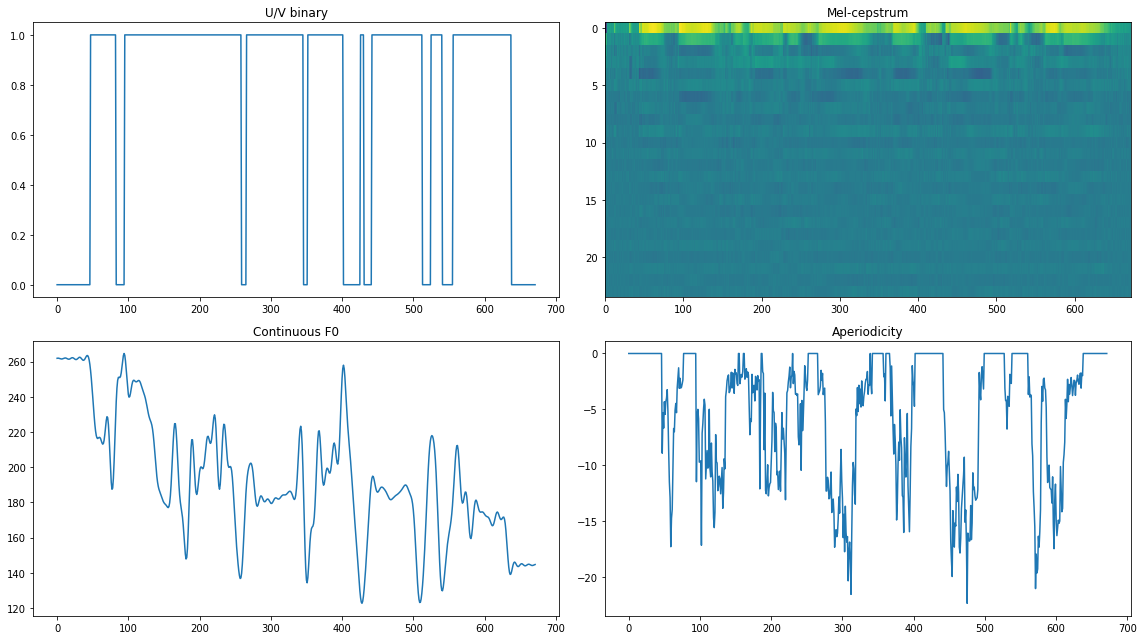

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.subplot(2, 2, 1)
plt.plot(feat[:, 0])
plt.title("U/V binary")
plt.subplot(2, 2, 3)
plt.plot(feat[:, 1])
plt.title("Continuous F0")
plt.subplot(2, 2, 2)
plt.imshow(feat[:, 2:26].T, aspect="auto")
plt.title("Mel-cepstrum")
plt.subplot(2, 2, 4)
plt.plot(feat[:, -1])
plt.title("Aperiodicity")
plt.tight_layout()
plt.show()

In [ ]:
# (Optional) here you can check the file with your commands!


### Stage 2: Statistics calculation

This stage calculates the mean and variance of features.

<div align="center">
    <img src=figs/stage_2.png width=70%>
</div>

In [30]:
# run stage 2 with default settings
!./run.sh --stage 2

###########################################################
#              CALCULATE STATISTICS STEP                  #
###########################################################
08/21/2019 12:23:26 (calc_stats:77) INFO: feats = data/tr_slt/feats.scp
08/21/2019 12:23:26 (calc_stats:77) INFO: stats = data/tr_slt/stats.h5
08/21/2019 12:23:26 (calc_stats:77) INFO: feature_type = world
08/21/2019 12:23:26 (calc_stats:77) INFO: verbose = 1
08/21/2019 12:23:26 (calc_stats:81) INFO: number of utterances = 32
08/21/2019 12:23:26 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0001.h5 (1/32)
08/21/2019 12:23:26 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0002.h5 (2/32)
08/21/2019 12:23:26 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0003.h5 (3/32)
08/21/2019 12:23:26 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0004.h5 (4/32)
08/21/2019 12:23:26 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0005.h5 (5/32)
08/21/2019 12:23:26 (calc_stats:

Calculated statistics are save as `hdf5` format in
- `data/tr_slt/stats.h5`

In [31]:
!tree -L 3 -I "*.f0|*.wav|*[0-9].h5" --filelimit 10

.
├── conf
├── data
│   ├── ev_slt
│   │   ├── feats.scp
│   │   └── wav.scp
│   └── tr_slt
│       ├── feats.scp
│       ├── stats.h5
│       ├── wav_filtered.scp
│       └── wav.scp
├── downloads
│   ├── cmu_us_awb_arctic_mini
│   │   └── wav
│   ├── cmu_us_bdl_arctic_mini
│   │   └── wav
│   ├── cmu_us_clb_arctic_mini
│   │   └── wav
│   ├── cmu_us_jmk_arctic_mini
│   │   └── wav
│   ├── cmu_us_ksp_arctic_mini
│   │   └── wav
│   ├── cmu_us_rms_arctic_mini
│   │   └── wav
│   ├── cmu_us_slt_arctic_mini
│   │   └── wav
│   └── COPYING
├── exp
│   ├── calculate_statistics
│   │   └── calc_stats_tr_slt.log
│   └── feature_extract
│       ├── feature_extract_ev_slt.log
│       └── feature_extract_tr_slt.log
├── hdf5
│   ├── ev_slt
│   └── tr_slt
├── path.sh
├── run.sh
└── wav
    ├── ev_slt
    └── tr_slt

28 directories, 12 files


`stats.h5` can be loaded as follows:

In [32]:
with h5py.File("data/tr_slt/stats.h5") as f:
    print(f.keys())
    print(f['world'].keys())
    mean = f['world']['mean'][()]
    scale = f['world']['scale'][()]
    print(mean.shape)
    print(scale.shape)
    
# or you use our utils
mean = read_hdf5("data/tr_slt/stats.h5", "world/mean")
scale = read_hdf5("data/tr_slt/stats.h5", "world/scale")

<KeysViewHDF5 ['world']>
<KeysViewHDF5 ['mean', 'scale']>
(28,)
(28,)


In [ ]:
# here you can check the file with your commands!


### Stage 3: Noise shaping

This stage applies noise shaping filter to training
wav files.

<div align="center">
    <img src=figs/stage_3.png width=70%>
</div>

In [33]:
# run stage 3 with default settings
!./run.sh --stage 3

###########################################################
#                   NOISE SHAPING STEP                    #
###########################################################
08/21/2019 12:24:07 (noise_shaping:154) INFO: waveforms = data/tr_slt/wav_filtered.scp
08/21/2019 12:24:07 (noise_shaping:154) INFO: stats = data/tr_slt/stats.h5
08/21/2019 12:24:07 (noise_shaping:154) INFO: outdir = wav_ns/tr_slt
08/21/2019 12:24:07 (noise_shaping:154) INFO: fs = 16000
08/21/2019 12:24:07 (noise_shaping:154) INFO: shiftms = 5.0
08/21/2019 12:24:07 (noise_shaping:154) INFO: feature_type = world
08/21/2019 12:24:07 (noise_shaping:154) INFO: mcep_dim_start = 2
08/21/2019 12:24:07 (noise_shaping:154) INFO: mcep_dim_end = 27
08/21/2019 12:24:07 (noise_shaping:154) INFO: mcep_alpha = 0.41
08/21/2019 12:24:07 (noise_shaping:154) INFO: mag = 0.5
08/21/2019 12:24:07 (noise_shaping:154) INFO: verbose = 1
08/21/2019 12:24:07 (noise_shaping:154) INFO: n_jobs = 10
08/21/2019 12:24:07 (noise_shaping:154) 

In [35]:
# Hyperparameters related to stage 3
!head -n 38 run.sh | tail -n 2

use_noise_shaping=true # whether to use noise shaping
mag=0.5                # strength of noise shaping (0.0 < mag <= 1.0)


If `use_noise_shaping=false`, `stage 3` will be skipped.

Note:
- Once you performed noise shaping,  
  coefficients of filter are saved in `stats.h5`.
- After saving, `mag` has no effect in the lator.
- If you want to change `mag`, please restart from `--stage 2` as follows.

In [ ]:
# remove old stats.h5
# !rm data/tr_slt/stats.h5

# re-calculate stats and perform noise shaping with mag
# !run.sh --stage 23 --mag 0.4

Noise shaping filtered wav files are saved in
- `wav_ns/tr_slt/*.wav`

The list
of noise shaping filtered wav files is saved as
- `data/tr_slt/wav_ns.scp`

In [36]:
!tree -L 3 -I "*.f0|*.wav|*[0-9].h5" --filelimit 10

.
├── conf
├── data
│   ├── ev_slt
│   │   ├── feats.scp
│   │   └── wav.scp
│   └── tr_slt
│       ├── feats.scp
│       ├── stats.h5
│       ├── wav_filtered.scp
│       ├── wav_ns.scp
│       └── wav.scp
├── downloads
│   ├── cmu_us_awb_arctic_mini
│   │   └── wav
│   ├── cmu_us_bdl_arctic_mini
│   │   └── wav
│   ├── cmu_us_clb_arctic_mini
│   │   └── wav
│   ├── cmu_us_jmk_arctic_mini
│   │   └── wav
│   ├── cmu_us_ksp_arctic_mini
│   │   └── wav
│   ├── cmu_us_rms_arctic_mini
│   │   └── wav
│   ├── cmu_us_slt_arctic_mini
│   │   └── wav
│   └── COPYING
├── exp
│   ├── calculate_statistics
│   │   └── calc_stats_tr_slt.log
│   ├── feature_extract
│   │   ├── feature_extract_ev_slt.log
│   │   └── feature_extract_tr_slt.log
│   └── noise_shaping
│       └── noise_shaping_apply_tr_slt.log
├── hdf5
│   ├── ev_slt
│   └── tr_slt
├── path.sh
├── run.sh
├── wav
│   ├── ev_slt
│   └── tr_slt
└── wav_ns
    └── tr_slt

31 directories, 14 files


Let us check the difference of waveform here.

In [37]:
# listen to the samples
import IPython.display
IPython.display.display(IPython.display.Audio("wav/tr_slt/arctic_a0001.wav"))
IPython.display.display(IPython.display.Audio("wav_ns/tr_slt/arctic_a0001.wav"))

Text(0.5, 1.0, 'Noise shaping filtered spectrogram')

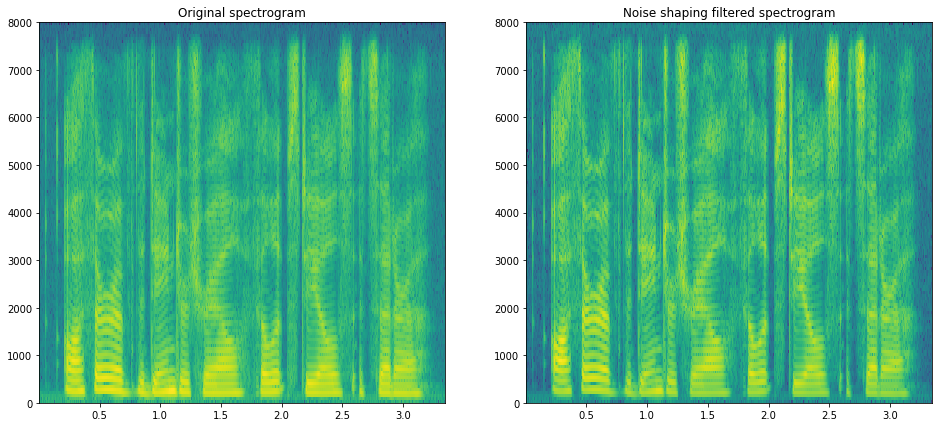

In [39]:
# show spectrogram
import soundfile as sf
import matplotlib.pyplot as plt
x, fs = sf.read("wav/tr_slt/arctic_a0001.wav")
x_ns, fs = sf.read("wav_ns/tr_slt/arctic_a0001.wav")
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.specgram(x, Fs=fs)
plt.title("Original spectrogram")
plt.subplot(1, 2, 2)
plt.specgram(x_ns, Fs=fs)
plt.title("Noise shaping filtered spectrogram") 

Filtering related parameters are added in `data/tr_slt/stats.h5`.

In [40]:
with h5py.File("data/tr_slt/stats.h5") as f:
    print(f.keys())
    print(f["mlsa"].keys())
    print(f["mlsa"]["alpha"])
    print(f["mlsa"]["coef"])

<KeysViewHDF5 ['mlsa', 'world']>
<KeysViewHDF5 ['alpha', 'coef']>
<HDF5 dataset "alpha": shape (), type "<f8">
<HDF5 dataset "coef": shape (25,), type "<f8">


`mlsa/coef` is the coefficient of MLSA filter, which is calculated from averaged mel-cepstrum.

In [ ]:
# (Optional) here you can check the file with your commands!


### Stage 4: WaveNet training

This stage trains WaveNet using extracted
features and noise shaping filtered wav files.

<div align="center">
    <img src=figs/stage_4.png width=70%>
</div>

In [41]:
# run stage 4 with default settings
!./run.sh --stage 4

###########################################################
#               WAVENET TRAINING STEP                     #
###########################################################
'data/tr_slt/stats.h5' -> 'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5'
08/21/2019 12:26:34 (train:413) INFO: waveforms = data/tr_slt/wav_ns.scp
08/21/2019 12:26:34 (train:413) INFO: feats = data/tr_slt/feats.scp
08/21/2019 12:26:34 (train:413) INFO: stats = data/tr_slt/stats.h5
08/21/2019 12:26:34 (train:413) INFO: expdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
08/21/2019 12:26:34 (train:413) INFO: feature_type = world
08/21/2019 12:26:34 (train:413) INFO: n_quantize = 256
08/21/2019 12:26:34 (train:413) INFO: n_aux = 28
08/21/2019 12:26:34 (train:413) INFO: n_resch = 32
08/21/2019 12:26:34 (train:413) INFO: n_skipch = 16
08/21/2019 12:26:34 (train:413) INFO: dilation_depth = 5
08/21/2019 

In [42]:
# Hyperparameters related to stage 4
!head -n 59 run.sh | tail -n 19

#######################################
#          TRAINING SETTING           #
#######################################
n_gpus=1                # number of gpus (default=1)
n_quantize=256          # number of quantization of waveform
n_aux=28                # number of auxliary features
n_resch=32              # number of residual channels
n_skipch=16             # number of skip channels
dilation_depth=5        # dilation depth (e.g. if set 10, max dilation = 2^(10-1))
dilation_repeat=1       # number of dilation repeats
kernel_size=2           # kernel size of dilated convolution
lr=1e-4                 # learning rate
weight_decay=0.0        # weight decay coef
iters=1000              # number of iterations
batch_length=10000      # batch length
batch_size=1            # batch size
checkpoint_interval=100 # save model per this number
use_upsampling=true     # whether to use upsampling layer
resume=""               # checkpoint paht to resume (Optional)


Default network structure in `egs/arctic/sd-mini`.
<div align="center">
    <img src=figs/wavenet.png width=70%>
</div>

Example when `dilation_depth=3` and `dilation_repeat=2`.

<div align="center">
    <img src=figs/structure_ex.png width=45%>
</div>

Make a batch by split a waveform into pieces.

<div align="center">
    <img src=figs/batch.png width=65%>
</div>

Model parameters are saved as  
- `exp/tr_arctic_16k_sd_world_slt_*/checkpoint-*.pkl` 

Modle configuration is saved as  
- `exp/tr_arctic_16k_sd_world_slt_*/model.conf`

The directory name is automatically set to be unique depending on hyperparameters.

In [45]:
!tree -L 3 -I "*.f0|*.wav|*[0-9].h5|*.scp|*.log" --filelimit 10

.
├── conf
├── data
│   ├── ev_slt
│   └── tr_slt
│       └── stats.h5
├── downloads
│   ├── cmu_us_awb_arctic_mini
│   │   └── wav
│   ├── cmu_us_bdl_arctic_mini
│   │   └── wav
│   ├── cmu_us_clb_arctic_mini
│   │   └── wav
│   ├── cmu_us_jmk_arctic_mini
│   │   └── wav
│   ├── cmu_us_ksp_arctic_mini
│   │   └── wav
│   ├── cmu_us_rms_arctic_mini
│   │   └── wav
│   ├── cmu_us_slt_arctic_mini
│   │   └── wav
│   └── COPYING
├── exp
│   ├── calculate_statistics
│   ├── feature_extract
│   ├── noise_shaping
│   └── tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up [14 entries exceeds filelimit, not opening dir]
├── hdf5
│   ├── ev_slt
│   └── tr_slt
├── path.sh
├── run.sh
├── wav
│   ├── ev_slt
│   └── tr_slt
└── wav_ns
    └── tr_slt

32 directories, 4 files


Model configuration file can be loaded as `argparse.Namespace`.

In [47]:
import torch
conf = torch.load("exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf")
print(conf)

Namespace(batch_length=10000, batch_size=1, checkpoint_interval=100, dilation_depth=5, dilation_repeat=1, expdir='exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up', feats='data/tr_slt/feats.scp', feature_type='world', intervals=100, iters=1000, kernel_size=2, lr=0.0001, n_aux=28, n_gpus=1, n_quantize=256, n_resch=32, n_skipch=16, resume='exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-500.pkl', seed=1, stats='data/tr_slt/stats.h5', upsampling_factor=80, use_speaker_code=False, use_upsampling_layer=1, verbose=1, waveforms='data/tr_slt/wav_ns.scp', weight_decay=0.0)


Model parameters `checkpoint-*.pkl` can be loaded as `dict` which contains
following information:
- `iterations`: Number of iterations of this parameters
- `optimizer`: `Dict` of states of optimizer
- `model`: `OrderedDict` of Model
parameters

In [48]:
state_dict = torch.load("exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-500.pkl")
print(state_dict.keys())
print(state_dict["iterations"])
print(state_dict["optimizer"].keys())
print(state_dict["model"].keys())

dict_keys(['model', 'optimizer', 'iterations'])
500
dict_keys(['state', 'param_groups'])
odict_keys(['causal.conv.weight', 'causal.conv.bias', 'upsampling.conv.weight', 'upsampling.conv.bias', 'dil_sigmoid.0.conv.weight', 'dil_sigmoid.0.conv.bias', 'dil_sigmoid.1.conv.weight', 'dil_sigmoid.1.conv.bias', 'dil_sigmoid.2.conv.weight', 'dil_sigmoid.2.conv.bias', 'dil_sigmoid.3.conv.weight', 'dil_sigmoid.3.conv.bias', 'dil_sigmoid.4.conv.weight', 'dil_sigmoid.4.conv.bias', 'dil_tanh.0.conv.weight', 'dil_tanh.0.conv.bias', 'dil_tanh.1.conv.weight', 'dil_tanh.1.conv.bias', 'dil_tanh.2.conv.weight', 'dil_tanh.2.conv.bias', 'dil_tanh.3.conv.weight', 'dil_tanh.3.conv.bias', 'dil_tanh.4.conv.weight', 'dil_tanh.4.conv.bias', 'aux_1x1_sigmoid.0.weight', 'aux_1x1_sigmoid.0.bias', 'aux_1x1_sigmoid.1.weight', 'aux_1x1_sigmoid.1.bias', 'aux_1x1_sigmoid.2.weight', 'aux_1x1_sigmoid.2.bias', 'aux_1x1_sigmoid.3.weight', 'aux_1x1_sigmoid.3.bias', 'aux_1x1_sigmoid.4.weight', 'aux_1x1_sigmoid.4.bias', 'aux_1x

You can resume training from `checkpoint-*.pkl` file with `--resume` options.

In [49]:
!./run.sh --stage 4 \
    --iters 1000 \
    --resume exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-500.pkl

###########################################################
#               WAVENET TRAINING STEP                     #
###########################################################
08/21/2019 12:29:02 (train:413) INFO: waveforms = data/tr_slt/wav_ns.scp
08/21/2019 12:29:02 (train:413) INFO: feats = data/tr_slt/feats.scp
08/21/2019 12:29:02 (train:413) INFO: stats = data/tr_slt/stats.h5
08/21/2019 12:29:02 (train:413) INFO: expdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
08/21/2019 12:29:02 (train:413) INFO: feature_type = world
08/21/2019 12:29:02 (train:413) INFO: n_quantize = 256
08/21/2019 12:29:02 (train:413) INFO: n_aux = 28
08/21/2019 12:29:02 (train:413) INFO: n_resch = 32
08/21/2019 12:29:02 (train:413) INFO: n_skipch = 16
08/21/2019 12:29:02 (train:413) INFO: dilation_depth = 5
08/21/2019 12:29:02 (train:413) INFO: dilation_repeat = 1
08/21/2019 12:29:02 (train:413) INFO: kernel_size = 2
08/21/2019 12:29:02 (train:413) I

You can train using multi-gpu with `--n_gpus` option.

In [50]:
# In colab, we can use only a single gpu :(
# !./run.sh --stage 4 --n_gpus 2 --batch_size 2

You can change hyperparameters via command line option.

In [51]:
!./run.sh --stage 4 --batch_length 5000 --iters 100

###########################################################
#               WAVENET TRAINING STEP                     #
###########################################################
'data/tr_slt/stats.h5' -> 'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl5000_bs1_ns_up/stats.h5'
08/21/2019 12:29:30 (train:413) INFO: waveforms = data/tr_slt/wav_ns.scp
08/21/2019 12:29:30 (train:413) INFO: feats = data/tr_slt/feats.scp
08/21/2019 12:29:30 (train:413) INFO: stats = data/tr_slt/stats.h5
08/21/2019 12:29:30 (train:413) INFO: expdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl5000_bs1_ns_up
08/21/2019 12:29:30 (train:413) INFO: feature_type = world
08/21/2019 12:29:30 (train:413) INFO: n_quantize = 256
08/21/2019 12:29:30 (train:413) INFO: n_aux = 28
08/21/2019 12:29:30 (train:413) INFO: n_resch = 32
08/21/2019 12:29:30 (train:413) INFO: n_skipch = 16
08/21/2019 12:29:30 (train:413) INFO: dilation_depth = 5
08/21/2019 12

Let us check the created files.

Because the directory name is automatically set
to be unique depending on hyperparameters, we do not care about overwriting.

In [52]:
!ls exp/tr_arctic*

exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up:
checkpoint-1000.pkl  checkpoint-400.pkl  checkpoint-800.pkl    model.conf
checkpoint-100.pkl   checkpoint-500.pkl  checkpoint-900.pkl    stats.h5
checkpoint-200.pkl   checkpoint-600.pkl  checkpoint-final.pkl
checkpoint-300.pkl   checkpoint-700.pkl  log

exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl5000_bs1_ns_up:
checkpoint-100.pkl  checkpoint-final.pkl  log  model.conf  stats.h5


In [ ]:
# here you can check the file with your commands!


### Stage 5: WaveNet decoding

This stage performs decoding of evaluation data.

<div align="center">
    <img src=figs/stage_5.png width=70%>
</div>

In [54]:
# run stage 5 with default setting
!./run.sh --stage 5

###########################################################
#               WAVENET DECODING STEP                     #
###########################################################
08/21/2019 12:29:53 (decode:223) INFO: feats = data/ev_slt/feats.scp
08/21/2019 12:29:53 (decode:223) INFO: checkpoint = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-final.pkl
08/21/2019 12:29:53 (decode:223) INFO: outdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav
08/21/2019 12:29:53 (decode:223) INFO: stats = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5
08/21/2019 12:29:53 (decode:223) INFO: config = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf
08/21/2019 12:29:53 (decode:223) INFO: fs = 16000
08/21/2019 12:29:53 (decode:223) INFO: batch_size = 4
08/21/2019 12:29:53

In [58]:
# Hyperparameters related to stage 5
!head -n 69 run.sh | tail -n 9

#######################################
#          DECODING SETTING           #
#######################################
outdir=""           # directory to save decoded wav dir (Optional)
checkpoint=""       # checkpoint path to be used for decoding (Optional)
config=""           # model configuration path (Optional)
stats=""            # statistics path (Optional)
feats=""            # list or directory of feature files (Optional)
decode_batch_size=4 # batch size in decoding


Generated wav files are saved in 
- `exp/tr_arctic_sd_tr_arctic_16k_sd_*/wav`

In [55]:
!tree exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up

exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
├── checkpoint-1000.pkl
├── checkpoint-100.pkl
├── checkpoint-200.pkl
├── checkpoint-300.pkl
├── checkpoint-400.pkl
├── checkpoint-500.pkl
├── checkpoint-600.pkl
├── checkpoint-700.pkl
├── checkpoint-800.pkl
├── checkpoint-900.pkl
├── checkpoint-final.pkl
├── log
│   └── tr_slt.log
├── model.conf
├── stats.h5
└── wav
    ├── arctic_b0092.wav
    ├── arctic_b0228.wav
    ├── arctic_b0435.wav
    ├── arctic_b0454.wav
    └── log
        └── decode.log

3 directories, 19 files


You can specify the `checkpoint-*.pkl` file used for decoding and directory to
be saved via `--checkpoint` and `--outdir` options.

In [ ]:
# it takes times, comment out
# !./run.sh --stage 5 \
#     --checkpoint exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-100.pkl
#     --outdir exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav_ckpt_100

We can use multi-gpu decoding via `--n_gpus` option.

In [ ]:
# In colab, we can use only a single gpu :(
# !./run.sh --stage 5 --n_gpus 2

In [ ]:
# (Optional) here you can check the file with your commands!


### Stage 6: Restore noise shaping

This stage applies inverse noise shaping
filter to generated wav files.

<div align="center">
    <img src=figs/stage_6.png width=70%>
</div>

In [56]:
# run stage 6 with default setting
!./run.sh --stage 6

###########################################################
#             RESTORE NOISE SHAPING STEP                  #
###########################################################
08/21/2019 12:31:41 (noise_shaping:154) INFO: waveforms = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav/wav.scp
08/21/2019 12:31:41 (noise_shaping:154) INFO: stats = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5
08/21/2019 12:31:41 (noise_shaping:154) INFO: outdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav_restored
08/21/2019 12:31:41 (noise_shaping:154) INFO: fs = 16000
08/21/2019 12:31:41 (noise_shaping:154) INFO: shiftms = 5.0
08/21/2019 12:31:41 (noise_shaping:154) INFO: feature_type = world
08/21/2019 12:31:41 (noise_shaping:154) INFO: mcep_dim_start = 2
08/21/2019 12:31:41 (noise_shaping:154) INFO: mcep_dim_end = 27
08/21/2019 12:3

Restored wav files are saved in

- `exp/tr_arctic_sd_tr_arctic_16k_sd_*/wav_restored`

In [57]:
!tree exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up

exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
├── checkpoint-1000.pkl
├── checkpoint-100.pkl
├── checkpoint-200.pkl
├── checkpoint-300.pkl
├── checkpoint-400.pkl
├── checkpoint-500.pkl
├── checkpoint-600.pkl
├── checkpoint-700.pkl
├── checkpoint-800.pkl
├── checkpoint-900.pkl
├── checkpoint-final.pkl
├── log
│   └── tr_slt.log
├── model.conf
├── stats.h5
├── wav
│   ├── arctic_b0092.wav
│   ├── arctic_b0228.wav
│   ├── arctic_b0435.wav
│   ├── arctic_b0454.wav
│   ├── log
│   │   └── decode.log
│   └── wav.scp
└── wav_restored
    ├── arctic_b0092.wav
    ├── arctic_b0228.wav
    ├── arctic_b0435.wav
    └── arctic_b0454.wav

4 directories, 24 files


In [ ]:
# (Optional) here you can check the file with your commands!


## Run the recipe with your own hyperparameters


Let us train sd-wavenet with bdl data without noise shaping.

In [ ]:
# !./run.sh --spk bdl --stage 0123456 --use_noise_shaping false

In the above case, we do not use noise shaping,  
so `stage 3` and `stage 6` are skipped.

Also, you can change only training related parameters.

In [ ]:
# !./run.sh --stage 456 --lr 1e-3 --weight_decay 1e-5 

## Use pretrained model as vocoder

Here weshow how-to-use pretrained model as
vocoder.  
What we need to prepare is following three files:

- `model.conf`:
Model configuration file.
- `checkpoint-*.pkl`: Model parameter file.
- `stats.h5`: Statistics file.

Let us pack following files into
`pretrained_model/` directory.

In [59]:
# summarize trained model in the directory
!mkdir pretrained_model
!cp -v exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5 \
    exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf \
    exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-1000.pkl \
    pretrained_model

'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5' -> 'pretrained_model/stats.h5'
'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf' -> 'pretrained_model/model.conf'
'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-1000.pkl' -> 'pretrained_model/checkpoint-1000.pkl'


First, please prepare the list file of feature files to be decoded.

In [60]:
import os
import numpy as np

# here make a dummy features and the stored as hdf5 with key "/world"
os.makedirs("dummy", exist_ok=True)
for idx, n_frames in enumerate([10, 20, 30, 40]): 
    x = np.random.randn(n_frames, 28)  # (#num_frames, #feature_dims)
    with h5py.File("dummy/dummy_%d.h5" % idx, "w") as f:
        f["world"] = x

# make a list of features to be decoded.
!find dummy -name "*.h5" > dummy_feats.scp

# check
!cat dummy_feats.scp

dummy/dummy_0.h5
dummy/dummy_1.h5
dummy/dummy_2.h5
dummy/dummy_3.h5


Run the `--stage 56` by specifying `--feats` in the recipe directory.

In [61]:
# decode with pretrained model through the recipe
!./run.sh --stage 56 \
    --outdir dummy_feats_wav \
    --feats dummy_feats.scp \
    --checkpoint pretrained_model/checkpoint-1000.pkl
!ls dummy_feats_wav*

###########################################################
#               WAVENET DECODING STEP                     #
###########################################################
08/21/2019 12:36:26 (decode:223) INFO: feats = dummy_feats.scp
08/21/2019 12:36:26 (decode:223) INFO: checkpoint = pretrained_model/checkpoint-1000.pkl
08/21/2019 12:36:26 (decode:223) INFO: outdir = dummy_feats_wav
08/21/2019 12:36:26 (decode:223) INFO: stats = pretrained_model/stats.h5
08/21/2019 12:36:26 (decode:223) INFO: config = pretrained_model/model.conf
08/21/2019 12:36:26 (decode:223) INFO: fs = 16000
08/21/2019 12:36:26 (decode:223) INFO: batch_size = 4
08/21/2019 12:36:26 (decode:223) INFO: n_gpus = 1
08/21/2019 12:36:26 (decode:223) INFO: intervals = 1000
08/21/2019 12:36:26 (decode:223) INFO: seed = 1
08/21/2019 12:36:26 (decode:223) INFO: verbose = 1
08/21/2019 12:36:34 (decode:314) INFO: decoding start
08/21/2019 12:36:37 (wavenet:483) INFO: 1000/3199 estimated time = 6.869 sec (0.003 sec / sa

If you want to use outside of the recipe, directly call python scripts stored in
`wavenet_vocoder/bin`.

In [62]:
# decode with pretrained model
!../../../wavenet_vocoder/bin/decode.py \
     --feats dummy_feats.scp \
     --outdir dummy_feats_wav_2 \
     --checkpoint pretrained_model/checkpoint-1000.pkl \
     --fs 16000 \
     --n_gpus 1 \
     --batch_size 4
# make list of wav files to be filtered
!find dummy_feats_wav_2 -name "*.wav" > dummy_feats_wav_2/wav.scp
# apply inverse noise shaping filter
!../../../wavenet_vocoder/bin/noise_shaping.py \
     --waveforms dummy_feats_wav_2/wav.scp \
     --outdir dummy_feats_wav_2_restored \
     --stats pretrained_model/stats.h5 \
     --fs 16000 \
     --shiftms 5
!ls dummy_feats_wav_2*

08/21/2019 12:37:07 (decode:223) INFO: feats = dummy_feats.scp
08/21/2019 12:37:07 (decode:223) INFO: checkpoint = pretrained_model/checkpoint-1000.pkl
08/21/2019 12:37:07 (decode:223) INFO: outdir = dummy_feats_wav_2
08/21/2019 12:37:07 (decode:223) INFO: stats = None
08/21/2019 12:37:07 (decode:223) INFO: config = None
08/21/2019 12:37:07 (decode:223) INFO: fs = 16000
08/21/2019 12:37:07 (decode:223) INFO: batch_size = 4
08/21/2019 12:37:07 (decode:223) INFO: n_gpus = 1
08/21/2019 12:37:07 (decode:223) INFO: intervals = 1000
08/21/2019 12:37:07 (decode:223) INFO: seed = 1
08/21/2019 12:37:07 (decode:223) INFO: verbose = 1
08/21/2019 12:37:13 (decode:314) INFO: decoding start
08/21/2019 12:37:17 (wavenet:483) INFO: 1000/3199 estimated time = 8.195 sec (0.004 sec / sample)
08/21/2019 12:37:20 (wavenet:483) INFO: 2000/3199 estimated time = 3.710 sec (0.003 sec / sample)
08/21/2019 12:37:23 (wavenet:483) INFO: 3000/3199 estimated time = 0.614 sec (0.003 sec / sample)
08/21/2019 12:37:24 

In this case, you can specify the directory instead of list.

In [63]:
!../../../wavenet_vocoder/bin/decode.py \
     --feats dummy \
     --outdir dummy_feats_wav_3 \
     --checkpoint pretrained_model/checkpoint-1000.pkl \
     --fs 16000 \
     --n_gpus 1 \
     --batch_size 4
!../../../wavenet_vocoder/bin/noise_shaping.py \
     --waveforms dummy_feats_wav_3 \
     --outdir dummy_feats_wav_3_restored \
     --stats pretrained_model/stats.h5 \
     --fs 16000 \
     --shiftms 5
!ls dummy_feats_wav_3*

08/21/2019 12:37:35 (decode:223) INFO: feats = dummy
08/21/2019 12:37:35 (decode:223) INFO: checkpoint = pretrained_model/checkpoint-1000.pkl
08/21/2019 12:37:35 (decode:223) INFO: outdir = dummy_feats_wav_3
08/21/2019 12:37:35 (decode:223) INFO: stats = None
08/21/2019 12:37:35 (decode:223) INFO: config = None
08/21/2019 12:37:35 (decode:223) INFO: fs = 16000
08/21/2019 12:37:35 (decode:223) INFO: batch_size = 4
08/21/2019 12:37:35 (decode:223) INFO: n_gpus = 1
08/21/2019 12:37:35 (decode:223) INFO: intervals = 1000
08/21/2019 12:37:35 (decode:223) INFO: seed = 1
08/21/2019 12:37:35 (decode:223) INFO: verbose = 1
08/21/2019 12:37:40 (decode:314) INFO: decoding start
08/21/2019 12:37:43 (wavenet:483) INFO: 1000/3199 estimated time = 6.579 sec (0.003 sec / sample)
08/21/2019 12:37:46 (wavenet:483) INFO: 2000/3199 estimated time = 3.488 sec (0.003 sec / sample)
08/21/2019 12:37:49 (wavenet:483) INFO: 3000/3199 estimated time = 0.580 sec (0.003 sec / sample)
08/21/2019 12:37:50 (decode:32

In [ ]:
print("running time = %s minite" % ((time.time() - start_time) / 60))

## Next steps

- Try another recipes
    - Multi-speaker recipe `egs/arctic/si-open`
    - Mel-spectrogram recipe `egs/ljspeech/sd-melspc`
- Combine with
[sprocket](https://github.com/k2kobayashi/sprocket)
- Combine with
[espnet](https://github.com/espnet/espnet)